In [8]:
!pip show tensorflow 

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\joez2\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [7]:
!pip install --upgrade tensorflow 

  Using cached tensorflow-2.16.2-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
Using cached tensorflow-2.16.2-cp312-cp312-win_amd64.whl (2.1 kB)



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
!pip install numpy transformers

     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     ----------------------------------- -- 41.0/43.6 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 43.6/43.6 kB 725.8 kB/s eta 0:00:00
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     --------- ------------------------------ 10.2/42.0 kB ? eta -:--:--
     -------------------------------------- 42.0/42.0 kB 511.8 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.6 kB 1.4 MB/s eta 0:00:01
     --------------------------- ---------- 41.0/57.6 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 508.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB 435.7 kB/s eta 0:00:22
   ------------


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# If using online colab, un comment this
# else ignore this cell
# from google.colab import drive
# drive.mount('/content/drive')

每10个epoch save一遍model, save output, 用val generate一遍output, 最后跑完再用test data generate一遍（这个我觉得可以等我们觉得model效果ok了以后再跑，防止他memorize test data）--》 用作对比for qualitative and quantitative data

再对d loss和g loss都画个图

解决一下生成出来时黑白的问题

train func也得改改




In [74]:
# setting up directories of the data
# can be different in everyone's local
# 本地存放数据的路径，每个人本地路径可能会有差异，改掉就好

# main
main_dir = "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric"

# colorful photo
photo_train_dir = main_dir + "\\photos_train_student_whiteBG"
photo_test_dir = main_dir + "\\photos_test_student_whiteBG"
photo_val_dir = main_dir + "\\photos_val_student_whiteBG"

# sketches
sketch_train_dir = main_dir + "\\sketch_train_studentSaved"
sketch_test_dir = main_dir + "\\sketch_test_studentSaved"
sketch_val_dir = main_dir + "\\sketch_val_studentSaved"
output_dir = main_dir + "\\output"

In [75]:
from torch.utils.data import Dataset
from PIL import Image
import os

# since our datasets of images do not have sub-directories,
# we can not use the normal torchvision's ImageFolder: torchvision.datasets.ImageFolder
# (the ImageFolder need us to have a sub-dir/sub-folder in side our datasets)
# Hence, we wrote our own ImagerFolder, reference by the documention of
# torchvision.datasets.ImageFolder
class ImageFolderDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('jpg', 'png', 'jpeg'))]
        print(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [76]:

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

import torchvision
photo_train_dataset = ImageFolderDataset(photo_train_dir, transform=transform)
photo_test_dataset = ImageFolderDataset(photo_test_dir, transform=transform)
photo_val_dataset = ImageFolderDataset(photo_val_dir, transform=transform)
sketch_train_dataset = ImageFolderDataset(sketch_train_dir, transform=transform)
sketch_test_dataset = ImageFolderDataset(sketch_test_dir, transform=transform)
sketch_val_dataset = ImageFolderDataset(sketch_val_dir, transform=transform)

['C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_0.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_1.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_10.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_100.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_101.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_102.jpg', 'C:\\Use

In [79]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 

Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [164]:
# Define the Generator
# G
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, features=64):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            self.contract_block(in_channels, features, False),
            self.contract_block(features, features * 2),
            self.contract_block(features * 2, features * 4),
            self.contract_block(features * 4, features * 8),
        )
        self.decoder = nn.Sequential(
            self.expand_block(features * 8, features * 4),
            self.expand_block(features * 4, features * 2),
            self.expand_block(features * 2, features),
            nn.ConvTranspose2d(features, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # encoder-decoder network
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def contract_block(self, in_channels, out_channels, use_bn=True):
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if use_bn:  # convolution-BatchNorm-ReLu
            block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.ReLU(inplace=True))
        return nn.Sequential(*block)

    def expand_block(self, in_channels, out_channels):
        block = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),  # convolution-BatchNorm-ReLu
            nn.ReLU(inplace=True),
        ]
        return nn.Sequential(*block)

# Define the Discriminator
# D
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels, features=64):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            self.discriminator_block(in_channels * 2, features, False),
            self.discriminator_block(features, features * 2),
            self.discriminator_block(features * 2, features * 4),
            nn.Conv2d(features * 4, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

    def discriminator_block(self, in_channels, out_channels, use_bn=True):
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if use_bn:
            block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*block)

# Training Loop
def train_gan(generator, discriminator, photo_dataloader, sketch_dataloader, val_dataloader, num_epochs=200, lambda_l1=100):
    # apply cuda to use gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    criterion_gan = nn.BCELoss()
    criterion_l1 = nn.L1Loss()

    # set up optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    output_dir = main_dir + "\\output"

    # create or link to output file
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        for i, (photo_batch, sketch_batch) in enumerate(zip(photo_dataloader, sketch_dataloader)):
            # apply cuda to use gpu
            photo_batch = photo_batch.to(device)
            sketch_batch = sketch_batch.to(device)

            # for debug only
            # print(photo_batch.size())
            # print(sketch_batch.size())

            # Train Discriminator
            optimizer_d.zero_grad()
            # The generator network G takes the input of x (e.g the sketches) and noise z to generate fake images
            fake_sketch = generator(sketch_batch)
            # D takes the real img and sketch to classify if it is fake
            real_validity = discriminator(photo_batch, sketch_batch)
            # The discriminator network D then takes in the fake image of G
            # along with real img to determine if the generated image G is fake.
            fake_validity = discriminator(photo_batch, fake_sketch.detach())

            # loss for real img for D
            real_loss = criterion_gan(real_validity, torch.ones_like(real_validity, device=device))
            # loss for fake img for D
            fake_loss = criterion_gan(fake_validity, torch.zeros_like(fake_validity, device=device))
            # disciminator loss
            d_loss = (real_loss + fake_loss)
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_validity = discriminator(photo_batch, fake_sketch)
            # loss for G
            gan_loss = criterion_gan(fake_validity, torch.ones_like(fake_validity, device=device))
            # L1 loss for pixel-wise diff
            l1_loss = criterion_l1(fake_sketch, photo_batch)
            # total G_loss = g_loss + λ*l1_loss
            g_loss = gan_loss + lambda_l1 * l1_loss
            g_loss.backward()
            optimizer_g.step()

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}\\{num_epochs}] Batch {i}\\{len(photo_dataloader)} Loss D: {d_loss.item()}, loss G: {g_loss.item()}")


        # Save some generated images for visualization
        if epoch % 10 == 0:
        # print(fake_sketch[0].size())
            save_image(fake_sketch[:1], f'{output_dir}\\{epoch}_generated.png', nrow=1, normalize=True)
            torch.save(generator.state_dict(), f'{output_dir}\\generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'{output_dir}\\discriminator_epoch_{epoch}.pth')

            # Generate output using validation data
            with torch.no_grad():
                for j, val_photo_batch in enumerate(val_dataloader):
                    val_photo_batch = val_photo_batch.to(device)
                    val_fake_sketch = generator(val_photo_batch)
                    save_image(val_fake_sketch[0:1], f'{output_dir}\\{epoch}_val_generated_{j}.png', nrow=1, normalize=True)
                    if j == 0:
                        break

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='G Loss')
    plt.plot(d_losses, label='D Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{output_dir}/loss_plot.png')
    plt.show()




In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

# 增加生成器和判别器的深度和复杂度
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, features=64):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            self.contract_block(in_channels, features, False),
            self.contract_block(features, features * 2),
            self.contract_block(features * 2, features * 4),
            self.contract_block(features * 4, features * 8),
            self.contract_block(features * 8, features * 16),  # 增加一个编码块
        )
        self.decoder = nn.Sequential(
            self.expand_block(features * 16, features * 8),
            self.expand_block(features * 8, features * 4),
            self.expand_block(features * 4, features * 2),
            self.expand_block(features * 2, features),
            nn.ConvTranspose2d(features, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def contract_block(self, in_channels, out_channels, use_bn=True):
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if use_bn:
            block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.ReLU(inplace=True))
        return nn.Sequential(*block)

    def expand_block(self, in_channels, out_channels):
        block = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        return nn.Sequential(*block)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels, features=64):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            self.discriminator_block(in_channels * 2, features, False),
            self.discriminator_block(features, features * 2),
            self.discriminator_block(features * 2, features * 4),
            self.discriminator_block(features * 4, features * 8),  # 增加一个判别块
            nn.Conv2d(features * 8, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

    def discriminator_block(self, in_channels, out_channels, use_bn=True):
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if use_bn:
            block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*block)

# 使用感知损失
class VGGPerceptualLoss(nn.Module):
    def __init__(self, feature_layer=34):
        super(VGGPerceptualLoss, self).__init__()
        self.vgg = nn.Sequential(*list(torchvision.models.vgg19(pretrained=True).features[:feature_layer])).eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        return nn.functional.l1_loss(x_vgg, y_vgg)

# 训练循环
def train_gan(generator, discriminator, photo_dataloader, sketch_dataloader, val_dataloader, num_epochs=200, lambda_l1=100, lambda_perceptual=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    criterion_gan = nn.BCELoss()
    criterion_l1 = nn.L1Loss()
    criterion_perceptual = VGGPerceptualLoss().to(device)

    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    output_dir = "output"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        for i, (photo_batch, sketch_batch) in enumerate(zip(photo_dataloader, sketch_dataloader)):
            photo_batch = photo_batch.to(device)
            sketch_batch = sketch_batch.to(device)

            # 训练判别器
            optimizer_d.zero_grad()
            fake_sketch = generator(sketch_batch)
            real_validity = discriminator(photo_batch, sketch_batch)
            fake_validity = discriminator(photo_batch, fake_sketch.detach())

            real_loss = criterion_gan(real_validity, torch.ones_like(real_validity, device=device))
            fake_loss = criterion_gan(fake_validity, torch.zeros_like(fake_validity, device=device))
            d_loss = (real_loss + fake_loss)
            d_loss.backward()
            optimizer_d.step()

            # 训练生成器
            optimizer_g.zero_grad()
            fake_validity = discriminator(photo_batch, fake_sketch)
            gan_loss = criterion_gan(fake_validity, torch.ones_like(fake_validity, device=device))
            l1_loss = criterion_l1(fake_sketch, photo_batch)
            perceptual_loss = criterion_perceptual(fake_sketch, photo_batch)
            g_loss = gan_loss + lambda_l1 * l1_loss + lambda_perceptual * perceptual_loss
            g_loss.backward()
            optimizer_g.step()

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(photo_dataloader)} Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

        if epoch % 10 == 0:
            save_image(fake_sketch[:1], f'{output_dir}/{epoch}_generated.png', nrow=1, normalize=True)
            torch.save(generator.state_dict(), f'{output_dir}/generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'{output_dir}/discriminator_epoch_{epoch}.pth')

            with torch.no_grad():
                for j, val_photo_batch in enumerate(val_dataloader):
                    val_photo_batch = val_photo_batch.to(device)
                    val_fake_sketch = generator(val_photo_batch)
                    save_image(val_fake_sketch[0:1], f'{output_dir}/{epoch}_val_generated_{j}.png', nrow=1, normalize=True)
                    if j == 0:
                        break

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='G Loss')
    plt.plot(d_losses, label='D Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{output_dir}/loss_plot.png')
    plt.show()

# 确保导入必要的模块
import torchvision
from torch.utils.data import DataLoader

# 假设有加载数据的代码
# photo_dataloader = ...
# sketch_dataloader = ...
# val_dataloader = ...

# 实例化生成器和判别器
generator = UNetGenerator(in_channels=1, out_channels=1)
discriminator = PatchDiscriminator(in_channels=1)

# 开始训练
# train_gan(generator, discriminator, photo_dataloader, sketch_dataloader, val_dataloader, num_epochs=200)


In [181]:
# Define the Generator
# G
class Block(nn.Module):
    #down: True means in encoder part of generator, False means in decoder part
    #act: default activation function is relu
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect")
            #down sampling after a single conv if encoding
            if down
            #if in decoder part perform upsampling
            else nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride = 2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
            # nn.ReLU(inplace=True) if act == "relu" else nn.LeakyReLU(0.2, inplace=True),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        #use dropout only in first 3 layers of UNet
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        #simple encoder-decoder architecture
        #encoder part, as layer become deeper, feature increase
        self.down1 = Block(features, features*2, down=True, act="leaky", use_dropout=False) #output img size 64
        self.down2 = Block(features*2, features*4, down=True, act="leaky", use_dropout=False) #32
        self.down3 = Block(features*4, features*8, down=True, act="leaky", use_dropout=False) #16
        self.down4 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) #8
        self.down5 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) #4
        self.down6 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) #2

        #bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, padding_mode="reflect"), #1x1 size
            nn.ReLU(),
        )

        #decoder part
        #as layer coming out of bottleneck, feature size decrease
        self.up1 = Block(features*8, features*8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act="relu", use_dropout=False)

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), #output pixel value between -1 to 1
        )

    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)

        u1 = self.up1(bottleneck)
        #use skip connection to concatenate encoder output with decoder input
        #inherit d7 from encoder and apply to u1 section
        #look at UNET it totally make sense in terms of skip connection
        #only difference is using single layer instead of double conv2 layer
        u2 = self.up2(torch.cat((u1,d7), dim=1))
        u3 = self.up3(torch.cat((u2,d6), dim=1))
        u4 = self.up4(torch.cat((u3,d5), dim=1))
        u5 = self.up5(torch.cat((u4,d4), dim=1))
        u6 = self.up6(torch.cat((u5,d3), dim=1))
        u7 = self.up7(torch.cat((u6,d2), dim=1))

        return self.final_up(torch.cat((u7,d1), dim=1))

# Define the Discriminator
# D
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels, features=64):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            self.discriminator_block(in_channels * 2, features, False),
            self.discriminator_block(features, features * 2),
            self.discriminator_block(features * 2, features * 4),
            nn.Conv2d(features * 4, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

    def discriminator_block(self, in_channels, out_channels, use_bn=True):
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if use_bn:
            block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*block)
    
    # Training Loop
def train_gan(generator, discriminator, photo_dataloader, sketch_dataloader, val_photo_dataloader, val_sketch_dataloader, num_epochs=10, lambda_l1=100):
    # apply cuda to use gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    criterion_gan = nn.BCELoss()
    criterion_l1 = nn.L1Loss()

    # set up optimizers
    # Add regularization techniques such as weight decay to the optimizers to prevent overfitting.
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # create or link to output file
    output1_dir = main_dir + '/output1'
    if not os.path.exists(output1_dir):
        os.makedirs(output1_dir)

    g_losses = []
    d_losses = []
    val_g_losses = []
    val_d_losses = []

    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = len(photo_dataloader)

        for i, (photo_batch, sketch_batch) in enumerate(zip(photo_dataloader, sketch_dataloader)):
            # apply cuda to use gpu
            photo_batch = photo_batch.to(device)
            sketch_batch = sketch_batch.to(device)

            # for debug only
            # print(photo_batch.size())
            # print(sketch_batch.size())

            # Train Discriminator
            optimizer_d.zero_grad()
            # The generator network G takes the input of x (e.g the sketches) and noise z to generate fake images
            fake_photo = generator(sketch_batch)
            # D takes the real img and sketch to classify if it is fake
            real_validity = discriminator(sketch_batch, photo_batch)
            # The discriminator network D then takes in the fake image of G
            # along with real img to determine if the generated image G is fake.
            fake_validity = discriminator(sketch_batch, fake_photo.detach())

            # loss for real img for D
            # Label Smoothing: Use label smoothing to reduce the confidence of the discriminator, which can help stabilize training.
            real_loss = criterion_gan(real_validity, torch.ones_like(real_validity, device=device) )
            # loss for fake img for D
            fake_loss = criterion_gan(fake_validity, torch.zeros_like(fake_validity, device=device) )
            # disciminator loss
            d_loss = (real_loss + fake_loss)
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_validity = discriminator(sketch_batch, fake_photo)
            # loss for G
            gan_loss = criterion_gan(fake_validity, torch.ones_like(fake_validity, device=device))
            # L1 loss for pixel-wise diff
            l1_loss = criterion_l1(fake_photo, photo_batch)
            # total G_loss = g_loss + λ*l1_loss
            g_loss = gan_loss + lambda_l1 * l1_loss
            g_loss.backward()
            optimizer_g.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        # Average the training losses for this epoch
        epoch_g_loss /= num_batches
        epoch_d_loss /= num_batches
        # Average the losses for this epoch
        g_losses.append(epoch_g_loss )
        d_losses.append(epoch_d_loss )

        # Validation
        generator.eval()
        val_g_loss = 0
        val_d_loss = 0
        with torch.no_grad():
            for i, (val_photo_batch, val_sketch_batch) in enumerate(zip(val_photo_dataloader, val_sketch_dataloader)):
                val_photo_batch = val_photo_batch.to(device)
                val_sketch_batch = val_sketch_batch.to(device)
                val_fake_photo = generator(val_photo_batch)

                real_validity = discriminator(val_sketch_batch, val_photo_batch)
                fake_validity = discriminator(val_sketch_batch, val_fake_photo)

                #val_loss += 100 * criterion_l1(val_fake_sketch, val_photo_batch).item() + criterion_gan(discriminator(val_photo_batch, val_fake_sketch), torch.ones_like(discriminator(val_photo_batch, val_fake_sketch))).item()
                val_g_loss += criterion_gan(fake_validity, torch.ones_like(fake_validity, device=device)).item() + lambda_l1 * criterion_l1(val_fake_photo, val_photo_batch).item()
                val_d_loss += criterion_gan(real_validity, torch.ones_like(real_validity, device=device)).item() + criterion_gan(fake_validity, torch.zeros_like(fake_validity, device=device)).item()


        val_g_loss /= len(val_photo_dataloader)
        val_d_loss /= len(val_photo_dataloader)
        val_g_losses.append(val_g_loss)
        val_d_losses.append(val_d_loss)
        generator.train()

        # Save some generated images for visualization
        if epoch % 10 == 0:
            # print(fake_sketch[0].size())
            save_image(fake_photo[:25], f'{output1_dir}/{epoch}_generated.png', nrow=5, normalize=True)
            torch.save(generator.state_dict(), f'{output1_dir}/generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'{output1_dir}/discriminator_epoch_{epoch}.pth')

            # Generate output using validation data
            with torch.no_grad():
                for j, val_photo_batch in enumerate(val_photo_dataloader):
                    val_photo_batch = val_photo_batch.to(device)
                    val_fake_photo_every_ten = generator(val_photo_batch)
                    save_image(val_fake_photo_every_ten, f'{output1_dir}/{epoch}_val_generated_{j}.png', nrow=5, normalize=True)
                    if j == 0:
                        break

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss G: {g_losses[-1]}, Loss D: {d_losses[-1]}, Val Loss G: {val_g_loss}, Val Loss D: {val_d_loss}")


    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Training G Loss')
    plt.plot(d_losses, label='Training D Loss')
    plt.plot(val_g_losses, label='Validation G Loss')
    plt.plot(val_d_losses, label='Validation D Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{output1_dir}/loss_plot.png')
    plt.show()

In [173]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_0.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_1.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_10.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_100.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_101.jpg', 'C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_train_student_whiteBG\\target_102.jpg', 'C:\\Use

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with R

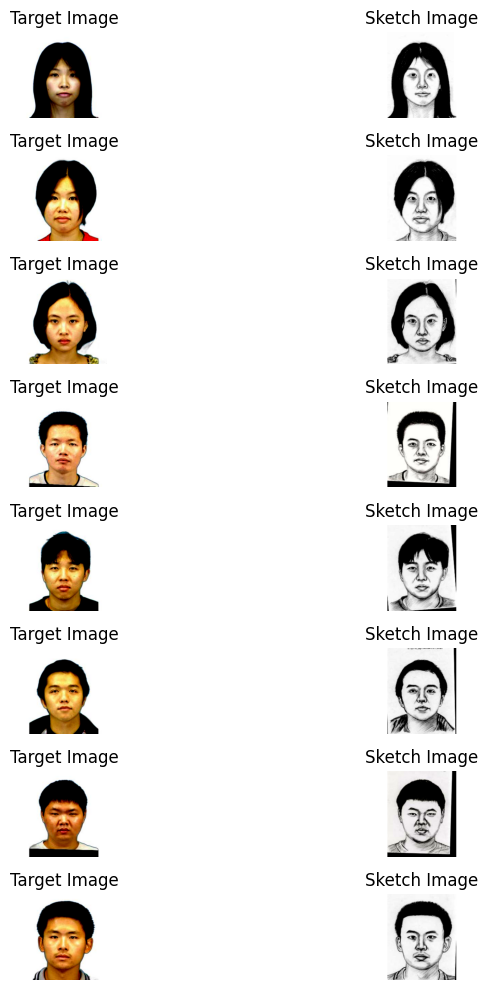

Epoch [1/100] Loss G: 70.76602300008138, Loss D: 1.3234326839447021, Val Loss G: 62.96688109636307, Val Loss D: 1.2474468350410461
Epoch [2/100] Loss G: 41.79616165161133, Loss D: 1.1730633179346721, Val Loss G: 45.97412544488907, Val Loss D: 1.2306269407272339
Epoch [3/100] Loss G: 31.145633061726887, Loss D: 1.0372781952222188, Val Loss G: 36.6097868680954, Val Loss D: 1.1064109802246094
Epoch [4/100] Loss G: 25.511618932088215, Loss D: 0.8946004112561544, Val Loss G: 30.862842798233032, Val Loss D: 0.9827935099601746
Epoch [5/100] Loss G: 21.98977247873942, Loss D: 0.7741632560888926, Val Loss G: 26.87106680870056, Val Loss D: 1.1616536378860474
Epoch [6/100] Loss G: 18.633830070495605, Loss D: 1.0351631144682567, Val Loss G: 25.645646512508392, Val Loss D: 1.1807172000408173
Epoch [7/100] Loss G: 17.044394493103027, Loss D: 0.8872158527374268, Val Loss G: 23.41612184047699, Val Loss D: 1.212615430355072
Epoch [8/100] Loss G: 15.673536459604898, Loss D: 1.1346864104270935, Val Loss 

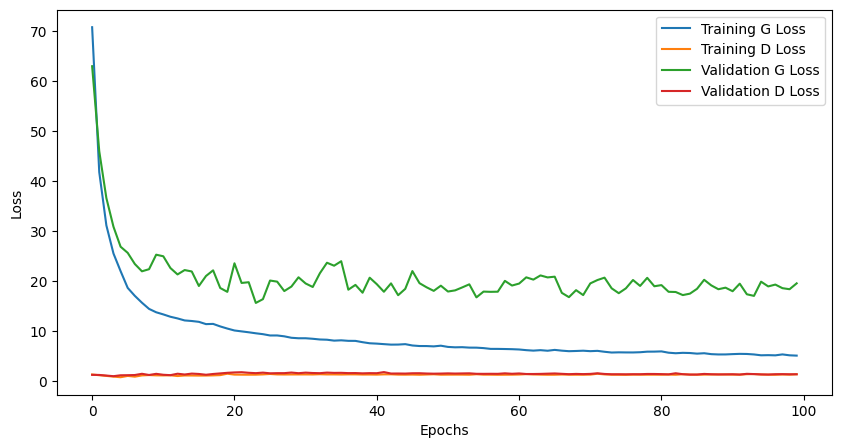

In [190]:
# Load datasets
photo_train_dataset = ImageFolderDataset(photo_train_dir, transform=transform)
photo_test_dataset = ImageFolderDataset(photo_test_dir, transform=transform)
photo_val_dataset = ImageFolderDataset(photo_val_dir, transform=transform)
sketch_train_dataset = ImageFolderDataset(sketch_train_dir, transform=transform)
sketch_test_dataset = ImageFolderDataset(sketch_test_dir, transform=transform)
sketch_val_dataset = ImageFolderDataset(sketch_val_dir, transform=transform)

photo_train_loader = DataLoader(photo_train_dataset, batch_size=32, shuffle=False)
photo_val_loader = DataLoader(photo_val_dataset, batch_size=32, shuffle=False)
photo_test_loader = DataLoader(photo_test_dataset, batch_size=32, shuffle=False)

# sketch
sketch_train_loader = DataLoader(sketch_train_dataset, batch_size=32, shuffle=False)
sketch_val_loader = DataLoader(sketch_val_dataset, batch_size=32, shuffle=False)
sketch_test_loader = DataLoader(sketch_test_dataset, batch_size=32, shuffle=False)

x = next(iter(photo_test_loader))[0]
print(x.shape)
# for debug!!!!
sample_batch = next(iter(photo_train_loader))
sample_batch2 = next(iter(sketch_train_loader))

x = sample_batch
x1 = sample_batch2
print(x.shape)
print(x1.shape)

print(x.dtype)
print(x1.dtype)

for i in range(min(len(x), len(x1))):
    print(f"Shape of photo sample {i}: {x[i].shape}")
    print(f"Shape of sketch sample {i}: {x1[i].shape}")

#set batchsize to corresponded batch size of val/train loader
fig, axes = plt.subplots(8, 2, figsize=(10, 10))
for i in range(8):
        axes[i, 0].imshow(x[i].permute(1, 2, 0))
        axes[i, 0].set_title('Target Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(x1[i].permute(1, 2, 0))
        axes[i, 1].set_title('Sketch Image')
        axes[i, 1].axis('off')


plt.tight_layout()
plt.show()

# Initialize models
generator = Generator(in_channels=3)
discriminator = PatchDiscriminator(in_channels=3)

# Train the model
train_gan(generator, discriminator, photo_train_loader, sketch_train_loader, photo_val_loader, sketch_val_loader, num_epochs=100)

In [ ]:
# # test the model:

# def load_checkpoint(checkpoint_file, model, optimizer, lr):
#     print("=> Loading checkpoint")
#     checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
#     model.load_state_dict(checkpoint["state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer"])

#     # If we don't do this then it will just have learning rate of old checkpoint
#     # and it will lead to many hours of debugging :
#     for param_group in optimizer.param_groups:
#         param_group["lr"] = lr

#     if config.LOADMODEL:
#         load_checkpoint(config.CHECKPOINT_GEN, gen, optimizer_gen, config.LEARNING_RATE)
#         load_checkpoint(config.CHECKPOINT_DISC, disc, optimizer_disc, config.LEARNING_RATE)
#         load_checkpoint(config.CHECKPOINT_GEN2, gen2, optimizer_gen2, config.LEARNING_RATE)


#     test_dataset = MapDataset_Multi(sketch_dir='test/sketch_crop', target_dir='test/photo_bright')
#     test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
#     print("Test dataset loaded")

#     if config.TEST_ONLY and config.LOAD_MODEL:

#         name = "Multi_FirstTrial"
#         if not os.path.exists(f"Final_Generation/g{name}"):
#             os.makedirs(f"FinalGeneration/g{name}")
#         finalsave_all(gen, gen2, test_loader, folderName=f"Final_Generation/g{name}")

#         exit()


# # L1 L2, MAE

In [ ]:
# SSIM
# 脸的轮廓match不match

# take in target and generated img


In [100]:
!pip install opencv-python-headless scikit-image


  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached imageio-2.34.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached tifffile-2024.7.2-py3-none-any.whl.metadata (30 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl (12.9 MB)
Using cached imageio-2.34.2-py3-none-any.whl (313 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.5 MB 751.6 kB/s eta 0:01:00
   ---------------

ERROR: Could not install packages due to an OSError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'C:\\Users\\joez2\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\scipy\\interpolate\\tests\\test_gil.py'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [108]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image_path1, image_path2):
    # 读取图像
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    # 检查图像是否加载成功
    if image1 is None or image2 is None:
        print("无法加载图像，请检查路径。")
        return

    # 计算 SSIM
    ssim_value, _ = ssim(image1, image2, full=True)

    print(f"SSIM: {ssim_value}")

# 示例调用
image_path1 = 'path/to/first/image.jpg'
image_path2 = 'path/to/second/image.jpg'
calculate_ssim(image_path1, image_path2)


无法加载图像，请检查路径。


In [117]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Define L1 loss function
l1_loss = nn.L1Loss()

# Define function to load model
def load_model(model, epoch, model_dir ='C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output'):
    model_path = os.path.join(model_dir, f'generator_epoch_{epoch}.pth')
    model.load_state_dict(torch.load(model_path))
    return model

# Define function to save output images
def save_output_image(output, epoch, batch_idx, output_dir='C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_image_path = os.path.join(output_dir, f'{epoch}_val_generated_0.png')
    output_image = output.squeeze().cpu().numpy()
    plt.imsave(output_image_path, output_image, cmap='gray')

# Define function to calculate L1 loss for each epoch
def calculate_l1_loss_per_epoch(model, dataloader, epoch_interval=10, output_dir='C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output', model_dir='C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output'):
    l1_losses = nn.L1Loss()
    model = generator
    epoch_l1_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = l1_loss(outputs, targets)
            epoch_l1_loss += loss.item()
            save_output_image(outputs, 1, batch_idx, output_dir=output_dir)
        l1_losses.append(epoch_l1_loss / len(dataloader))
    print(f'Epoch {1}: L1 Loss = {epoch_l1_loss / len(dataloader)}')
    return l1_losses

# Example usage
if __name__ == '__main__':
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define your model
    class SimpleModel(nn.Module):
        def __init__(self):
            super(SimpleModel, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        
        def forward(self, x):
            x = torch.relu(self.conv1(x))
            x = self.conv2(x)
            return x
    
    model = UNetGenerator(in_channels=3, out_channels=3).to(device)

    # Load dataset (example using MNIST)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    test_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Calculate L1 loss per epoch and save output images
    x = next(iter(test_loader))[0]
    print(x.shape)
    l1_losses = calculate_l1_loss_per_epoch(model, test_loader)

torch.Size([32, 1, 28, 28])


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os

# Define your dataset and DataLoader (modify as per your dataset)
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transforms as needed
])
dataset = YourDataset(...)  # Replace with your actual dataset initialization
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define your model (modify as per your model)
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Define your model layers here

    def forward(self, x):
        # Define the forward pass
        return x

# Initialize your model and loss function
model = YourModel()
criterion = nn.L1Loss()

# Function to calculate L1 loss for every epoch using saved model and output
def calculate_l1_loss(saved_model_path, dataloader):
    model.load_state_dict(torch.load(saved_model_path))
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            # Save image every batch
            save_image(outputs, f'output_batch_{batch_idx}.png')
    epoch_loss = total_loss / len(dataloader)
    return epoch_loss

# Example usage:
saved_model_path = 'path_to_your_saved_model.pth'
epoch_loss = calculate_l1_loss(saved_model_path, dataloader)
print(f"L1 loss for epoch using model {saved_model_path}: {epoch_loss}")

In [144]:
pip install opencv-python-headless matplotlib scikit-image


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [193]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
model = Generator(in_channels=3)
model_dirc = main_dir + '/output1/generator_epoch_90.pth'
state_dict = torch.load(model_dirc)
model.load_state_dict(state_dict)
model.eval()
output_dir = os.path.join(main_dir, 'output')
def save_images(input_image, generated_image, index):
    input_image_path = os.path.join(output_dir, f'input_image_{index}.png')
    generated_image_path = os.path.join(output_dir, f'generated_image_{index}.png')
    save_image(input_image, input_image_path)
    save_image(generated_image, generated_image_path)
    # load data
photo_test_loader = DataLoader(photo_test_dataset, batch_size=1, shuffle=False)

# sketch
sketch_test_loader = DataLoader(sketch_test_dataset, batch_size=1, shuffle=False)


ModuleNotFoundError: No module named 'distutils'

In [145]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

def compare_images(imageA, imageB):
    # 计算 SSIM
    ssim_value, diff = ssim(imageA, imageB, full=True)
    return ssim_value, diff

def load_image(image_path):
    # 读取图像并转换为灰度图
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"无法加载图像: {image_path}")
    return image

def save_comparison_figure(image_paths1, image_paths2, output_path):
    num_images = len(image_paths1)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5 * num_images))

    # for i in range(num_images):
    image1 = load_image(image_paths1)
    image2 = load_image(image_paths2)
    
    ssim_value, diff = compare_images(image1, image2)
    
    # 显示原始图像、对比图像和差异图像
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title("Compared Image")
    axes[1].axis('off')

    axes[2].imshow(diff, cmap='gray')
    axes[2].set_title(f"SSIM: {ssim_value:.4f}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# 示例用法

image_paths1 = "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\0_generated.png"
image_paths2 = "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg"

output_path =  "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output"
save_comparison_figure(image_paths1, image_paths2, output_path)


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

Error in callback <function _draw_all_if_interactive at 0x00000135D6167CE0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1000x66000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1000x66000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x66000 with 396 Axes>

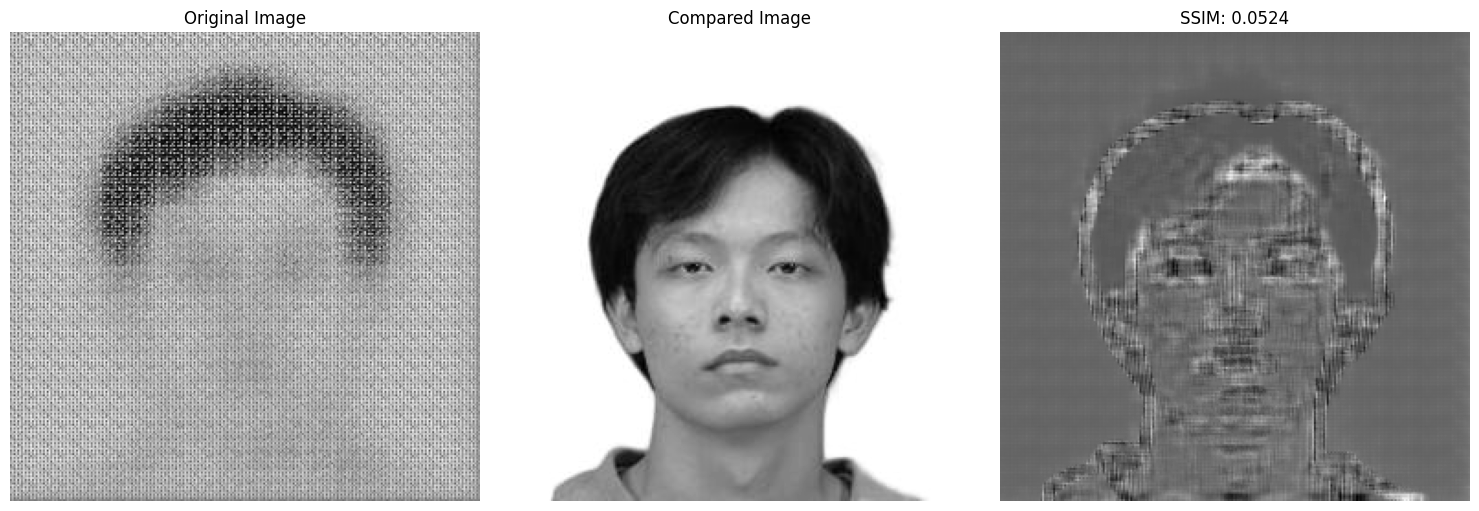

In [146]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def compare_images(imageA, imageB):
    # Compute SSIM
    ssim_value, diff = ssim(imageA, imageB, full=True)
    return ssim_value, diff

def load_image(image_path):
    # Read the image and convert to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Unable to load image: {image_path}")
    return image

def save_comparison_figure(image_path1, image_path2, output_path):
    image1 = load_image(image_path1)
    image2 = load_image(image_path2)
    
    ssim_value, diff = compare_images(image1, image2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display original image, compared image, and difference image
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title("Compared Image")
    axes[1].axis('off')

    axes[2].imshow(diff, cmap='gray')
    axes[2].set_title(f"SSIM: {ssim_value:.4f}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Example usage
image_path1 = "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\0_generated.png"
image_path2 = "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg"

output_path = "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\comparison.png"
save_comparison_figure(image_path1, image_path2, output_path)

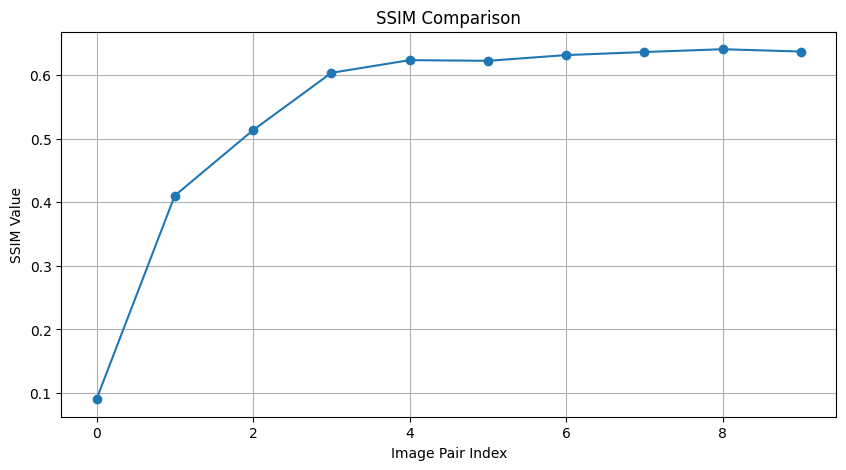

Average SSIM: 0.5410


In [168]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

def compare_images(imageA, imageB):
    # Compute SSIM
    ssim_value, diff = ssim(imageA, imageB, full=True)
    return ssim_value, diff

def load_image(image_path):
    # Read the image and convert to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Unable to load image: {image_path}")
    return image

def collect_ssim_data(image_paths1, image_paths2):
    ssim_values = []
    for path1, path2 in zip(image_paths1, image_paths2):
        image1 = load_image(path1)
        image2 = load_image(path2)
        ssim_value, _ = compare_images(image1, image2)
        ssim_values.append(ssim_value)
    return ssim_values

def plot_ssim_comparison(ssim_values, output_path):
    
    plt.figure(figsize=(10, 5))
    plt.plot(ssim_values, marker='o')
    plt.title('SSIM Comparison')
    plt.xlabel('Image Pair Index')
    plt.ylabel('SSIM Value')
    plt.grid(True)
    plt.savefig(output_path)
    plt.show()

# Example usage
image_paths1 = [
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\0_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\10_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\20_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\30_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\40_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\50_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\60_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\70_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\80_generated.png",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output\\90_generated.png"
    
]

image_paths2 = [
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg",
    "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\photos_test_student_whiteBG\\m1-009-01.jpg"
]

ssim_values = collect_ssim_data(image_paths1, image_paths2)
output_path = "C:\\Users\\joez2\\OneDrive\\Desktop\\360\\APS360_Group18_SketchToFace_GAN-eric\\APS360_Group18_SketchToFace_GAN-eric\\output"
plot_ssim_comparison(ssim_values, output_path)

average_ssim = np.mean(ssim_values)
print(f"Average SSIM: {average_ssim:.4f}")


In [192]:
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader
from torchvision.utils import save_image

class Generator(nn.Module):
    # 定义你的生成器模型
    def __init__(self, in_channels):
        super(Generator, self).__init__()
        # 定义生成器的网络结构，这里是一个简单示例
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# 加载模型
model = Generator(in_channels=3)
model_dirc = main_dir + '\\output1\\generator_epoch_90.pth'
state_dict = torch.load(model_dirc, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

output_dir = os.path.join(main_dir, 'output')

def save_images(input_image, generated_image, index):
    input_image_path = os.path.join(output_dir, f'input_image_{index}.png')
    generated_image_path = os.path.join(output_dir, f'generated_image_{index}.png')
    save_image(input_image, input_image_path)
    save_image(generated_image, generated_image_path)

# 加载数据
photo_test_loader = DataLoader(photo_test_dataset, batch_size=1, shuffle=False)
sketch_test_loader = DataLoader(sketch_test_dataset, batch_size=1, shuffle=False)

# 生成和保存图像
with torch.no_grad():
    for index, (photo, sketch) in enumerate(zip(photo_test_loader, sketch_test_loader)):
        generated_image = model(sketch)
        save_images(photo, generated_image, index)


RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias", "main.3.weight", "main.3.bias", "main.3.running_mean", "main.3.running_var", "main.5.weight", "main.5.bias", "main.6.weight", "main.6.bias", "main.6.running_mean", "main.6.running_var", "main.8.weight", "main.8.bias", "main.9.weight", "main.9.bias", "main.9.running_mean", "main.9.running_var", "main.11.weight", "main.11.bias", "main.12.weight", "main.12.bias", "main.12.running_mean", "main.12.running_var", "main.14.weight", "main.14.bias". 
	Unexpected key(s) in state_dict: "initial_down.0.weight", "initial_down.0.bias", "down1.conv.0.weight", "down1.conv.1.weight", "down1.conv.1.bias", "down1.conv.1.running_mean", "down1.conv.1.running_var", "down1.conv.1.num_batches_tracked", "down2.conv.0.weight", "down2.conv.1.weight", "down2.conv.1.bias", "down2.conv.1.running_mean", "down2.conv.1.running_var", "down2.conv.1.num_batches_tracked", "down3.conv.0.weight", "down3.conv.1.weight", "down3.conv.1.bias", "down3.conv.1.running_mean", "down3.conv.1.running_var", "down3.conv.1.num_batches_tracked", "down4.conv.0.weight", "down4.conv.1.weight", "down4.conv.1.bias", "down4.conv.1.running_mean", "down4.conv.1.running_var", "down4.conv.1.num_batches_tracked", "down5.conv.0.weight", "down5.conv.1.weight", "down5.conv.1.bias", "down5.conv.1.running_mean", "down5.conv.1.running_var", "down5.conv.1.num_batches_tracked", "down6.conv.0.weight", "down6.conv.1.weight", "down6.conv.1.bias", "down6.conv.1.running_mean", "down6.conv.1.running_var", "down6.conv.1.num_batches_tracked", "bottleneck.0.weight", "bottleneck.0.bias", "up1.conv.0.weight", "up1.conv.1.weight", "up1.conv.1.bias", "up1.conv.1.running_mean", "up1.conv.1.running_var", "up1.conv.1.num_batches_tracked", "up2.conv.0.weight", "up2.conv.1.weight", "up2.conv.1.bias", "up2.conv.1.running_mean", "up2.conv.1.running_var", "up2.conv.1.num_batches_tracked", "up3.conv.0.weight", "up3.conv.1.weight", "up3.conv.1.bias", "up3.conv.1.running_mean", "up3.conv.1.running_var", "up3.conv.1.num_batches_tracked", "up4.conv.0.weight", "up4.conv.1.weight", "up4.conv.1.bias", "up4.conv.1.running_mean", "up4.conv.1.running_var", "up4.conv.1.num_batches_tracked", "up5.conv.0.weight", "up5.conv.1.weight", "up5.conv.1.bias", "up5.conv.1.running_mean", "up5.conv.1.running_var", "up5.conv.1.num_batches_tracked", "up6.conv.0.weight", "up6.conv.1.weight", "up6.conv.1.bias", "up6.conv.1.running_mean", "up6.conv.1.running_var", "up6.conv.1.num_batches_tracked", "up7.conv.0.weight", "up7.conv.1.weight", "up7.conv.1.bias", "up7.conv.1.running_mean", "up7.conv.1.running_var", "up7.conv.1.num_batches_tracked", "final_up.0.weight", "final_up.0.bias". 